In [1]:
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
from sklearn.utils import shuffle

import sys
sys.path.append('../')
from src import *

random.seed(1234)
np.random.seed(1234)

In [2]:
PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
OUTPUT_DIR = "/extra/disij0/data/flow_cytometry/flowMP_output/"
PATH_TABLE = '/home/disij/projects/acdc/data/AML_benchmark/'

Load AML data from 21 samples, 5 of them are healthy (H\*), 16 of them are AML samples (SJ\*). Here I use the correct prior information table by "table.at['Mature B cells','CD38'] = -1.0"

In [3]:
# load data into a dictionary of pandas data frames
user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)

In [4]:
markers = ['HLA-DR','CD19','CD34','CD45','CD47','CD44','CD117','CD123','CD38','CD11b',\
                'CD7','CD15','CD3','CD64','CD33','CD41']
    
table = pd.read_csv(PATH_TABLE + 'AML_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table = table[markers]

cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
cell_type_idx2name = {i:x for i,x in enumerate(table.index)}

In [5]:
table.at['Mature B cells','CD38'] = -1.0

Now run MCMC to collect posterior samples...

#### Training models for healthy samples

In [6]:
f = lambda x: np.arcsinh((x -1.)/5.)
data = [data_dict[_].head(10000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4','H5']]

# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [7]:
%%time

n_mcmc_chain = 32
n_mcmc_sample = 1000
mcmc_gaussian_std = 0.05
random_effect_gaussian_std = 0.5

pooled_data = np.concatenate(data)

accepts_template_mp_H = []
accepts_indiv_mp_lists_H = [[] for id in range(5)]

chains = range(n_mcmc_chain)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(mcmc_RE)(theta_space, table, data, pooled_data, \
                    n_mcmc_sample, mcmc_gaussian_std, random_effect_gaussian_std, i) for i in chains)

for _ in results:
    accepts_template_mp_H.append(_[0])
    for id in range(n_samples):
        accepts_indiv_mp_lists_H[id].append(_[1][id])

Chain 7: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 7, 3, 2, 3, 5, 112
Chain 23: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 6, 4, 5, 2, 7, 119
Chain 1: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 11, 5, 7, 6, 12, 124
Chain 17: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 2, 0, 4, 2, 12, 108
Chain 21: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 8, 2, 5, 3, 14, 126
Chain 19: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 4, 6, 5, 9, 12, 125
Chain 31: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 5, 5, 8, 3, 13, 127
Chain 3: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 6, 5, 3, 2, 10, 124
Chain 4: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 8, 8, 8, 4, 12, 129
Chain 22: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 5, 3, 4, 2, 6, 126
Chain 10: Drawing Sample 2

In [8]:
write_chains_to_file(accepts_template_mp_H, OUTPUT_DIR + 'MP_RE_accepted_template_samples_H')
for id in range(5):
    write_chains_to_file(accepts_indiv_mp_lists_H[id], \
                         OUTPUT_DIR + 'MP_RE_accepted_indiv_samples_H%d' % (id+1))

Ensemble K most probable chains...


We compare all chains by the maximum of log likehood on each chain. Then we keep the top K chains that has largest log likelihood, in each chain, we only keep the sample that has the greatest log likelihood.

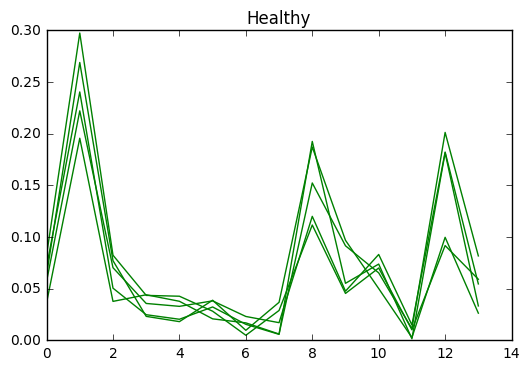

In [9]:
K = 5

population_size_H = [None for _ in range(n_samples)]

for id in range(n_samples):
    # compute log likelihood of size n_mcmc_chain * accepted_samples for each subject
    logl_accepted_trace = []
    for chain_id in range(n_mcmc_chain):
        logl_accepted_trace.append([])
        template_mp = accepts_template_mp_H[chain_id][-1]
        for indiv_mp in accepts_indiv_mp_lists_H[id][chain_id]:
            val = joint_logP_Random_Effect(template_mp,[indiv_mp],[data[id]], \
                                           table, random_effect_gaussian_std)
            logl_accepted_trace[chain_id].append(val)
    
    # select top K samples
    max_logl_per_chain = [max(logl_accepted_trace[i]) for i in range(n_mcmc_chain)]
    topK_chain_id = sorted(range(n_mcmc_chain), key=lambda i: max_logl_per_chain[i])[-K:]

    topK_samples = []
    topK_predictions = []
    for i in range(K):
        chain_id = topK_chain_id[i]
        sample_id = logl_accepted_trace[chain_id].index(max(logl_accepted_trace[chain_id]))
        sample = accepts_indiv_mp_lists_H[id][chain_id][sample_id]
        topK_samples.append(sample)
        topK_predictions.append(classify_cells(data[id], sample,table, cell_type_name2idx))

    # vote to classify cells
    votes = np.zeros([data[id].shape[0], table.shape[0]])
    for Y_predict in topK_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)
    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_H[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_H[id],color = 'g')
plt.title('Healthy')
plt.show()

#### Training models for unhealthy samples

In [6]:
f = lambda x: np.arcsinh((x -1.)/5.)
data = [data_dict[_].head(10000).applymap(f)[markers].values for _ in ['SJ01','SJ02',\
            'SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [9]:
%%time

n_mcmc_chain = 32
n_mcmc_sample = 1000
mcmc_gaussian_std = 0.05
random_effect_gaussian_std = 0.5

pooled_data = np.concatenate(data)

accepts_template_mp_SJ = []
accepts_indiv_mp_lists_SJ = [[] for id in range(16)]

# chains = range(n_mcmc_chain)
# num_cores = multiprocessing.cpu_count()

# results = Parallel(n_jobs=num_cores)(delayed(mcmc_RE)(theta_space, table, data, pooled_data, \
#                     n_mcmc_sample, mcmc_gaussian_std, random_effect_gaussian_std, i) for i in chains)

# for _ in results:
#     accepts_template_mp_SJ.append(_[0])
#     for id in range(n_samples):
#         accepts_indiv_mp_lists_SJ[id].append(_[1][id])

for i in range(n_mcmc_chain):
    result = mcmc_RE(theta_space, table, data, pooled_data, n_mcmc_sample, \
                     mcmc_gaussian_std, random_effect_gaussian_std, i)
    accepts_template_mp_SJ.append(result[0])
    for id in range(n_samples):
        accepts_indiv_mp_lists_SJ[id].append(result[1][id])

Chain 0: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 6, 18, 12, 13, 9, 106
Chain 0: Drawing Sample 400 ...
Accepted proposals of indiv mp, template mp: 20, 33, 21, 25, 23, 281
Chain 0: Drawing Sample 600 ...
Accepted proposals of indiv mp, template mp: 29, 38, 31, 35, 30, 475
Chain 0: Drawing Sample 800 ...
Accepted proposals of indiv mp, template mp: 35, 45, 34, 36, 41, 673
Chain 0: Drawing Sample 1000 ...
Accepted proposals of indiv mp, template mp: 40, 53, 47, 47, 57, 873
Chain 1: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 9, 16, 3, 11, 7, 93
Chain 1: Drawing Sample 400 ...
Accepted proposals of indiv mp, template mp: 19, 24, 12, 19, 17, 274
Chain 1: Drawing Sample 600 ...
Accepted proposals of indiv mp, template mp: 21, 28, 27, 29, 24, 460
Chain 1: Drawing Sample 800 ...
Accepted proposals of indiv mp, template mp: 26, 42, 38, 36, 28, 660
Chain 1: Drawing Sample 1000 ...
Accepted proposals of indiv mp, template mp: 59, 74, 60, 50, 50

../src/flowMP_compute.py:31: RuntimeWarning: divide by zero encountered in log
  return np.log(multivariate_normal.pdf(data, mean=mu, cov=cov)).sum()


Chain 12: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 10, 23, 12, 20, 5, 81
Chain 12: Drawing Sample 400 ...
Accepted proposals of indiv mp, template mp: 21, 29, 23, 28, 11, 241
Chain 12: Drawing Sample 600 ...
Accepted proposals of indiv mp, template mp: 32, 35, 29, 39, 19, 430
Chain 12: Drawing Sample 800 ...
Accepted proposals of indiv mp, template mp: 37, 46, 37, 49, 31, 629
Chain 12: Drawing Sample 1000 ...
Accepted proposals of indiv mp, template mp: 40, 60, 54, 68, 50, 829
Chain 13: Drawing Sample 200 ...
Accepted proposals of indiv mp, template mp: 9, 20, 8, 16, 12, 103
Chain 13: Drawing Sample 400 ...
Accepted proposals of indiv mp, template mp: 25, 29, 13, 25, 22, 269
Chain 13: Drawing Sample 600 ...
Accepted proposals of indiv mp, template mp: 39, 34, 15, 34, 23, 463
Chain 13: Drawing Sample 800 ...
Accepted proposals of indiv mp, template mp: 43, 48, 25, 39, 31, 660
Chain 13: Drawing Sample 1000 ...
Accepted proposals of indiv mp, template mp: 53, 80

In [10]:
write_chains_to_file(accepts_template_mp_SJ, OUTPUT_DIR + 'MP_RE_accepted_template_samples_SJ')
for id in range(16):
    write_chains_to_file(accepts_indiv_mp_lists_SJ[id], \
                         OUTPUT_DIR + 'MP_RE_accepted_indiv_samples_SJ%d' % (id+1))

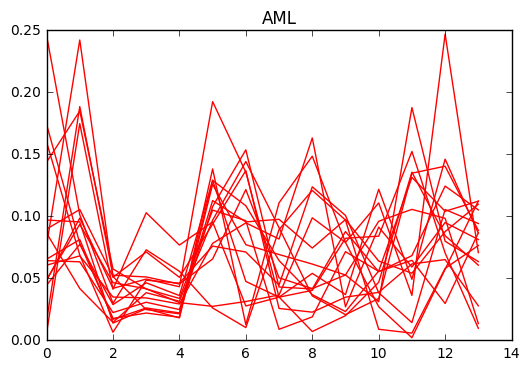

In [11]:
K = 5

population_size_SJ = [None for _ in range(n_samples)]

for id in range(n_samples):
    # compute log likelihood of size n_mcmc_chain * accepted_samples for each subject
    logl_accepted_trace = []
    for chain_id in range(n_mcmc_chain):
        logl_accepted_trace.append([])
        template_mp = accepts_template_mp_SJ[chain_id][-1]
        for indiv_mp in accepts_indiv_mp_lists_SJ[id][chain_id]:
            val = joint_logP_Random_Effect(template_mp,[indiv_mp],[data[id]], \
                                           table, random_effect_gaussian_std)
            logl_accepted_trace[chain_id].append(val)
    
    # select top K samples
    max_logl_per_chain = [max(logl_accepted_trace[i]) for i in range(n_mcmc_chain)]
    topK_chain_id = sorted(range(n_mcmc_chain), key=lambda i: max_logl_per_chain[i])[-K:]

    topK_samples = []
    topK_predictions = []
    for i in range(K):
        chain_id = topK_chain_id[i]
        sample_id = logl_accepted_trace[chain_id].index(max(logl_accepted_trace[chain_id]))
        sample = accepts_indiv_mp_lists_SJ[id][chain_id][sample_id]
        topK_samples.append(sample)
        topK_predictions.append(classify_cells(data[id], sample,table, cell_type_name2idx))

    # vote to classify cells
    votes = np.zeros([data[id].shape[0], table.shape[0]])
    for Y_predict in topK_predictions:
        for _ in range(len(Y_predict)):
            votes[_,Y_predict[_]] += 1
    Y_predict_majority = np.argmax(votes, axis=1)
    Y_predict_majority = [cell_type_idx2name[_] for _ in Y_predict_majority]
    population_size_SJ[id] = [Y_predict_majority.count(_)*1.0 / len(Y_predict_majority) \
                             for _ in table.index]

for id in range(n_samples):
    plt.plot(population_size_SJ[id],color = 'r')
plt.title('AML')
plt.show()

#### Diagnosis...

In [17]:
# reload data!

data = [data_dict[_].head(20000).applymap(f)[markers].values for _ in ['H1','H2','H3','H4',\
            'H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
            'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']]
 
# compute data range 
data_ranges = np.array([[[data[_][:,d].min(),data[_][:,d].max()] \
                        for d in range(len(markers))]
                        for _ in range(len(data))])

theta_space = np.array([[data_ranges[:,d,0].min(), data_ranges[:,d,1].max()] \
                        for d in range(len(markers))])

n_samples = len(data)

In [15]:
# load samples from file

accepts_template_mp_H = load_chains_from_files(OUTPUT_DIR + 'MP_RE_accepted_template_samples_H')
accepts_template_mp_SJ = load_chains_from_files(OUTPUT_DIR + 'MP_RE_accepted_template_samples_SJ')

accepts_indiv_mp_H = [[] for id in range(5)]
accepts_indiv_mp_SJ = [[] for id in range(16)]

for id in range(5):
    accepts_indiv_mp_H[id] = load_chains_from_files(OUTPUT_DIR + \
                                                    'MP_RE_accepted_indiv_samples_H%d' % (id+1))
for id in range(16):
    accepts_indiv_mp_SJ[id] = load_chains_from_files(OUTPUT_DIR + \
                                                    'MP_RE_accepted_indiv_samples_SJ%d' % (id+1))

Logistic regression with cell population of under 2 templates as features

In [23]:
%%time

# step 1: learn cell populations of all samples, under 2 template MPs, 5 chains
# V: cell proportion for 21 samples under healthy template
V_H = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]
V_SJ = [[None for chain in range(n_mcmc_chain)] for _ in range(21)]


chains = range(n_mcmc_chain)
num_cores = multiprocessing.cpu_count()


for id in range(21):
    print id
    res_H = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (data[id],accepts_template_mp_H[i][-1],theta_space) \
                                       for i in range(n_mcmc_chain))
    indiv_MP_condition_template_H = [_[1][-1] for _ in res_H]
    for chain in range(n_mcmc_chain):
        V_H[id][chain] = compute_cell_population(data[id], \
                            indiv_MP_condition_template_H[chain:chain+1], \
                                      table, cell_type_name2idx, cell_type_idx2name)
    
    res_SJ = Parallel(n_jobs=num_cores)(delayed(mcmc_condition_on_template)\
                            (data[id],accepts_template_mp_SJ[i][-1],theta_space) \
                                        for i in range(n_mcmc_chain))
    indiv_MP_condition_template_SJ = [_[1][-1] for _ in res_SJ]
    for chain in range(n_mcmc_chain):
        V_SJ[id][chain] = compute_cell_population(data[id], \
                                    indiv_MP_condition_template_SJ[chain:chain+1], \
                                      table, cell_type_name2idx, cell_type_idx2name)

0
Accepted proposals of indiv mp, template mp: 35
Accepted proposals of indiv mp, template mp: 34
Accepted proposals of indiv mp, template mp: 45
Accepted proposals of indiv mp, template mp: 61
Accepted proposals of indiv mp, template mp: 43
Accepted proposals of indiv mp, template mp: 50
Accepted proposals of indiv mp, template mp: 23
Accepted proposals of indiv mp, template mp: 32
Accepted proposals of indiv mp, template mp: 42
Accepted proposals of indiv mp, template mp: 39
Accepted proposals of indiv mp, template mp: 55
Accepted proposals of indiv mp, template mp: 39
Accepted proposals of indiv mp, template mp: 32
Accepted proposals of indiv mp, template mp: 38
Accepted proposals of indiv mp, template mp: 40
Accepted proposals of indiv mp, template mp: 36
Accepted proposals of indiv mp, template mp: 20
Accepted proposals of indiv mp, template mp: 31
Accepted proposals of indiv mp, template mp: 48
Accepted proposals of indiv mp, template mp: 36
Accepted proposals of indiv mp, templa

In [ ]:
# save V_H and V_SJ to file

In [31]:
from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model
import matplotlib.pyplot as plt
import numpy as np
    
def LOO(X,Y):
    loo = LeaveOneOut()
    models = []
    X = np.array(X)
    Y = np.array(Y)

    predict_prob = []
    for train, test in loo.split(X,Y):
        train_X = X[train]
        train_Y = Y[train]
        test_X = X[test]
        test_Y = Y[test]
        logreg = linear_model.LogisticRegression(C=1e5)
        logreg.fit(train_X, train_Y)
        test_Y_predict = logreg.predict(test_X)
        models.append(logreg)
        predict_prob.append(logreg.predict_proba(test_X)[0][0])

    plt.scatter(range(21),predict_prob,s = 100)
    plt.xlim(0, 21)
    plt.ylim(0, 1)
    groups = ['H%s' % i for i in range(1,6)] + ['SJ%s' % i for i in range(1,17)]
    plt.legend()

    plt.xticks(range(21),groups)
    plt.ylabel('P(healthy)')
    plt.title('P(healthy) Predicted by LOOCV Logistic Regression')
    plt.show()
    
    return predict_prob,models

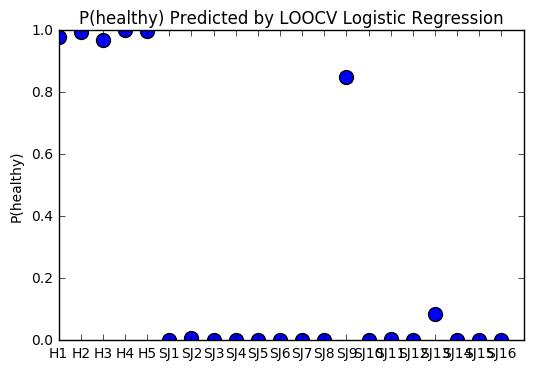

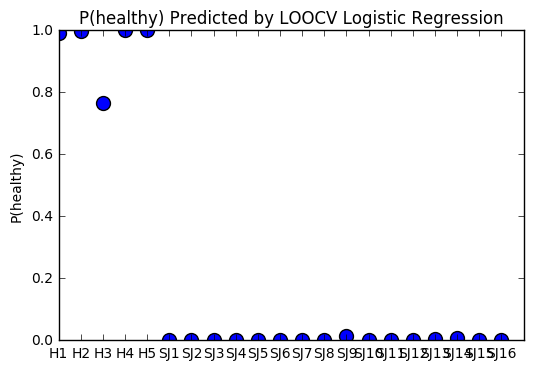

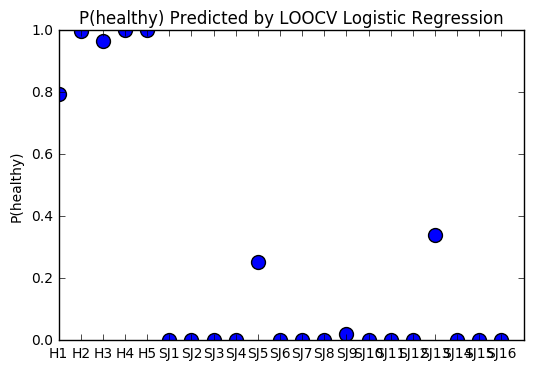

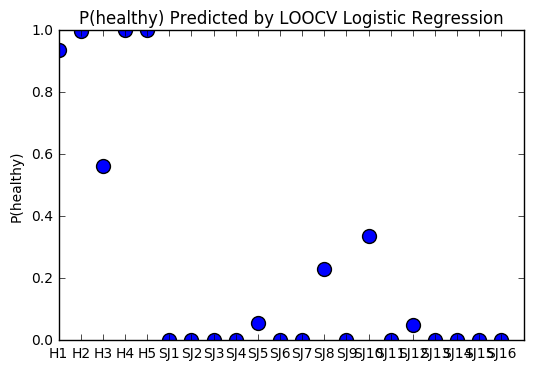

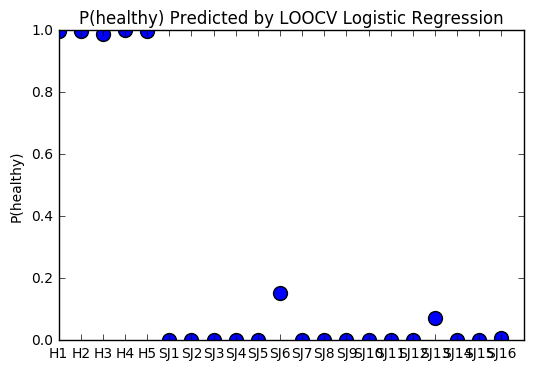

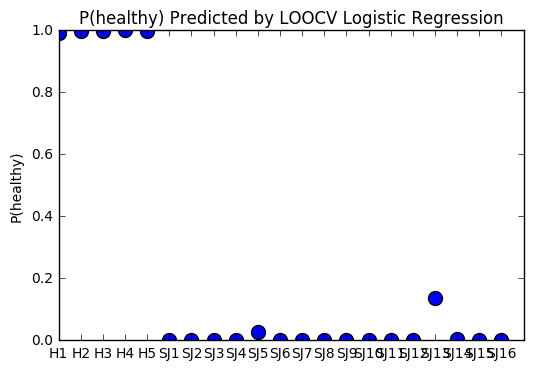

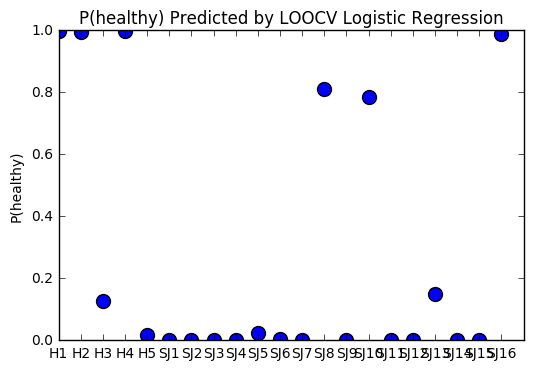

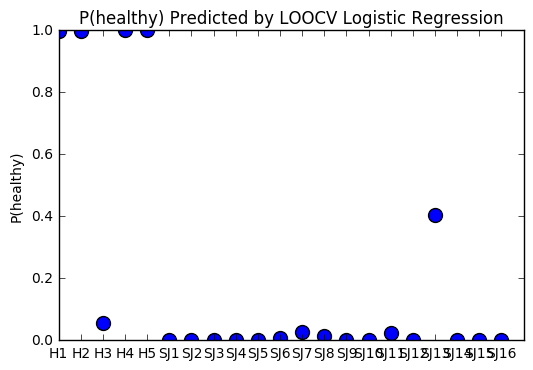

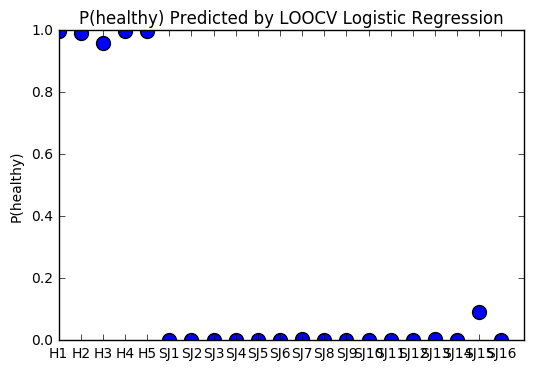

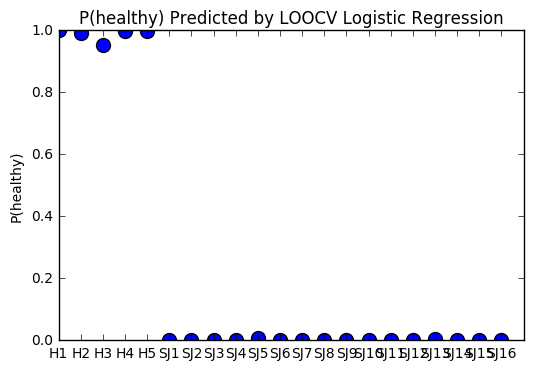

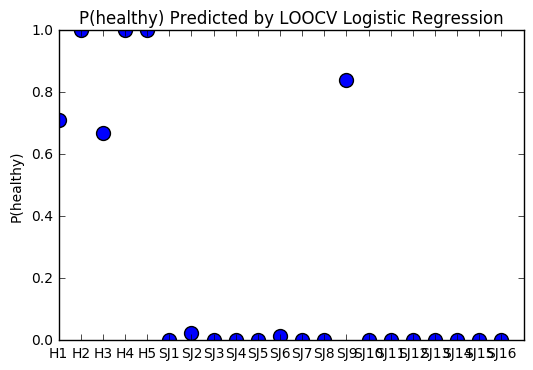

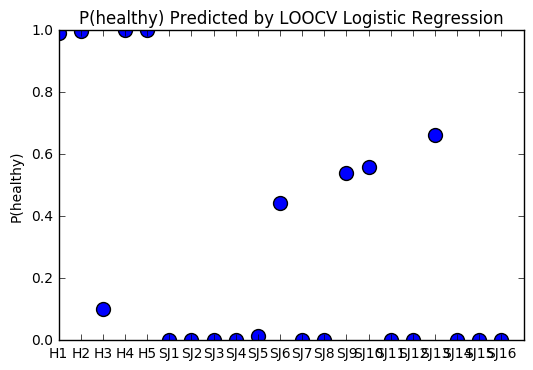

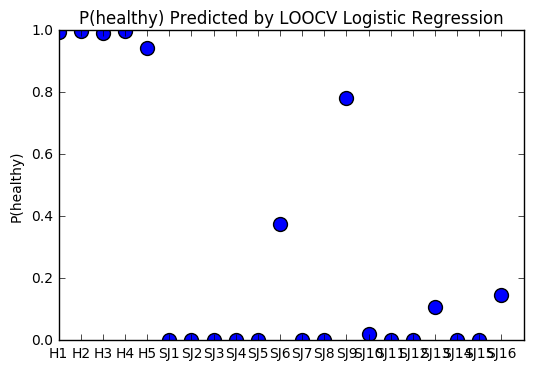

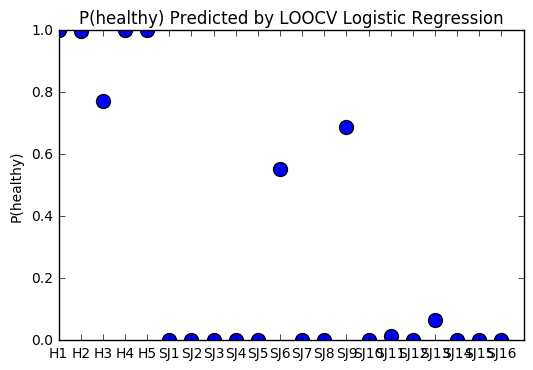

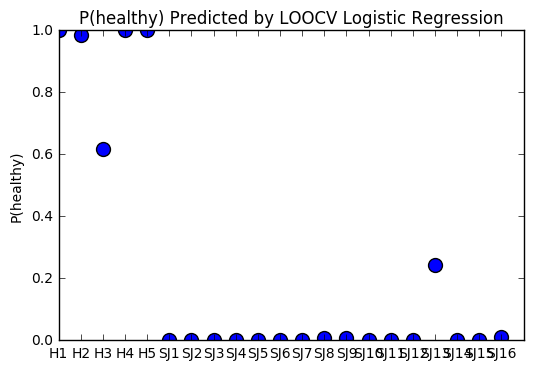

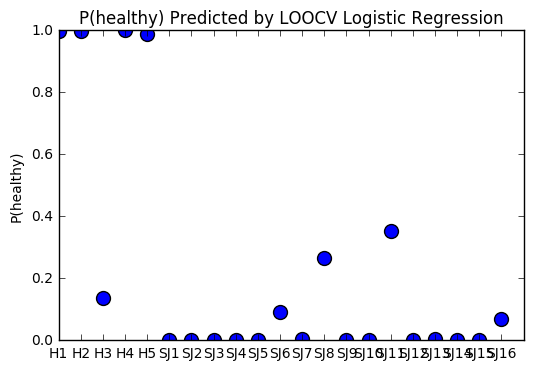

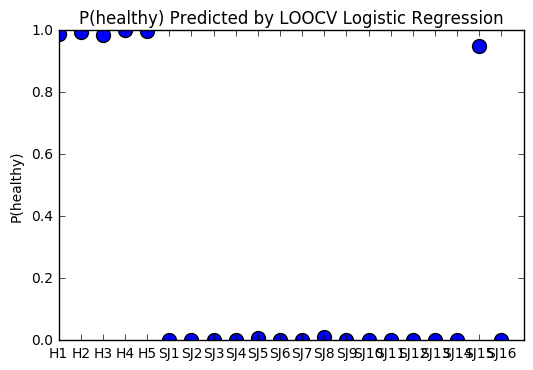

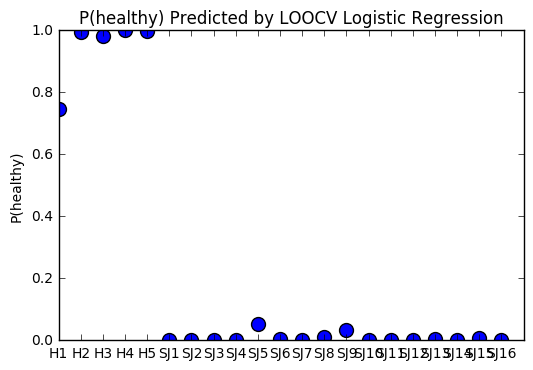

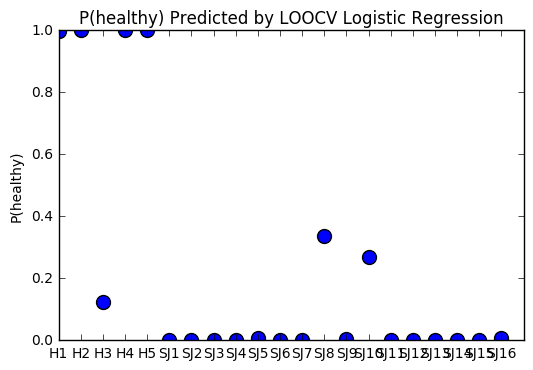

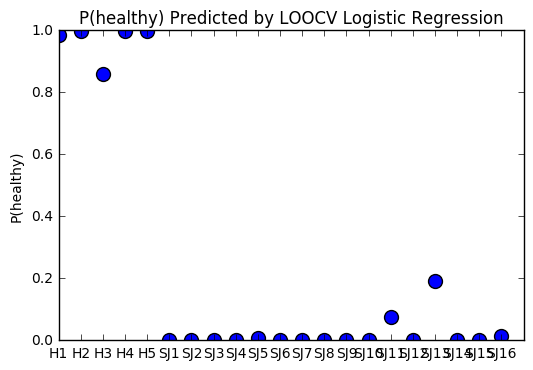

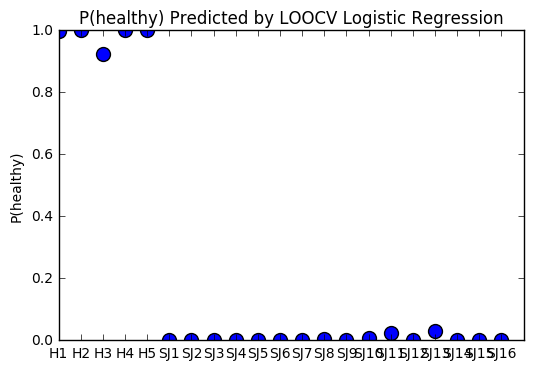

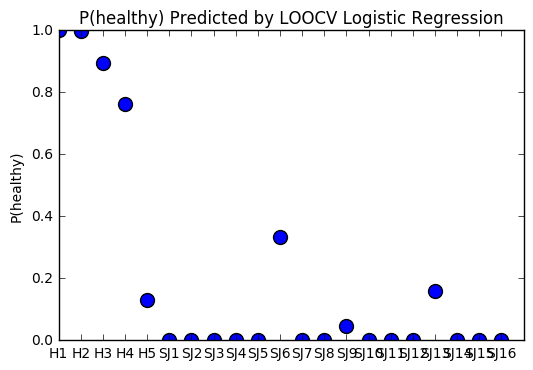

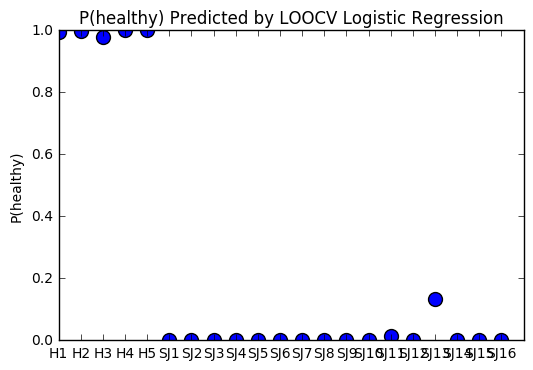

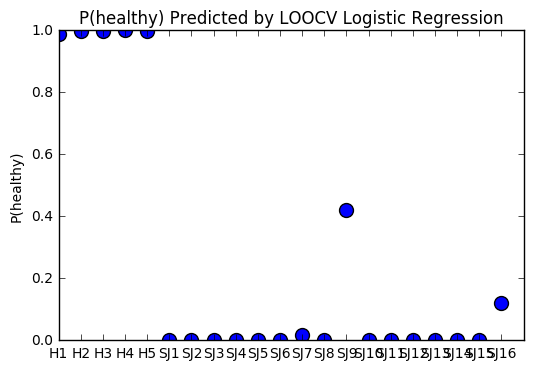

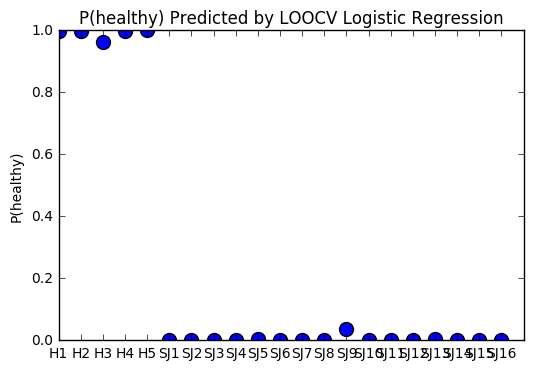

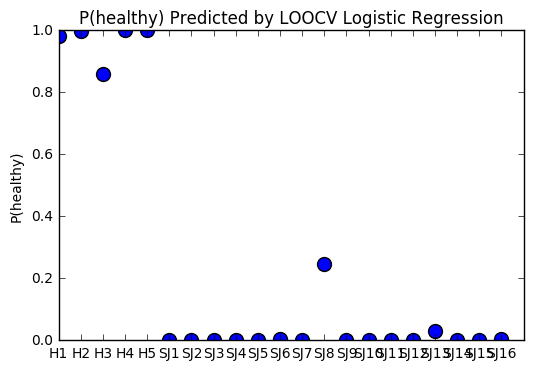

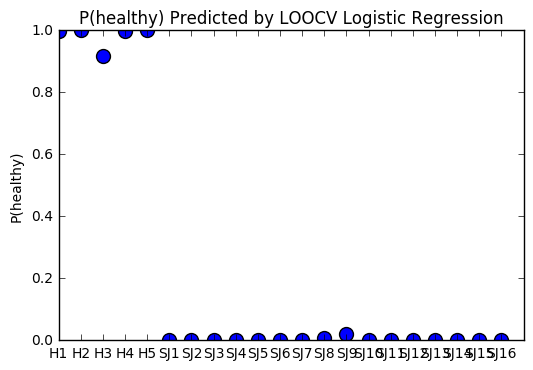

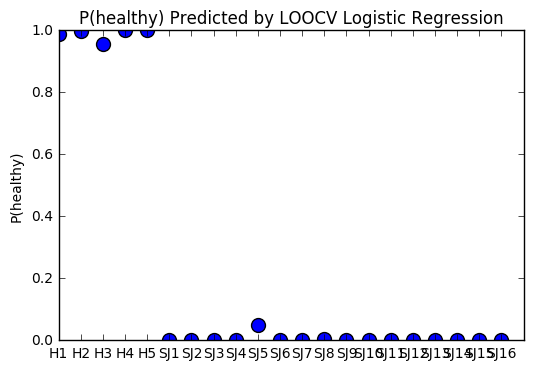

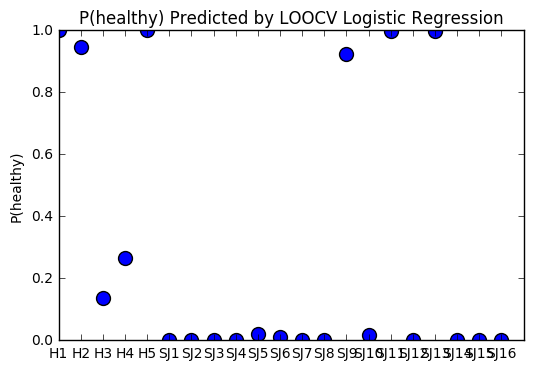

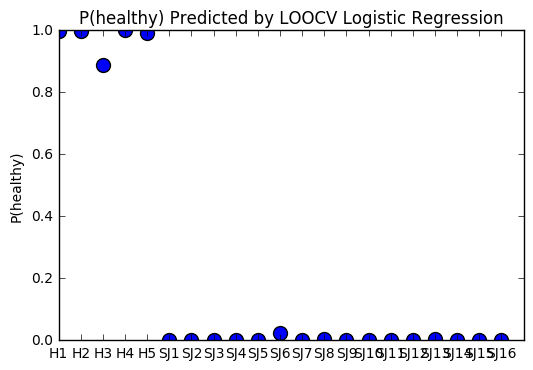

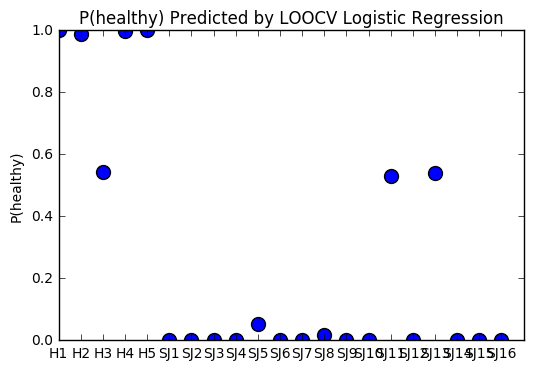

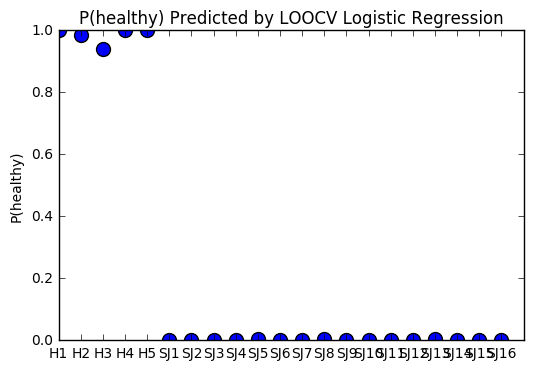

In [32]:
X = [[V_H[id][chain] + V_SJ[id][chain] for id in range(21)] for chain in range(n_mcmc_chain)]
Y = [0]*5 + [1]*16


predict_prob,models = [],[]
for chain in range(n_mcmc_chain):
    res = LOO(X[chain],Y)
    predict_prob.append(res[0])
    models.append(res[1])

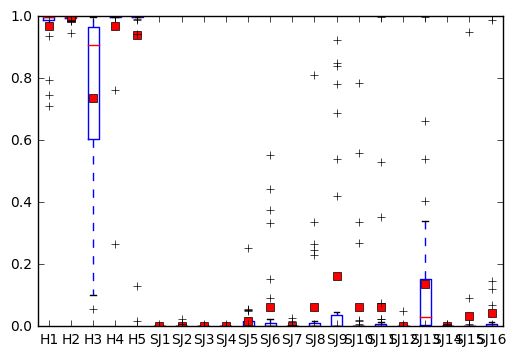

In [46]:
predict_prob = np.array(predict_prob)
groups = ['H%s' % i for i in range(1,6)] + ['SJ%s' % i for i in range(1,17)]
plt.figure()
plt.boxplot(predict_prob,labels=groups,showmeans=True)
plt.show()